#Study showing neural network use for fraud detection
Using Neural Networks to detect energy meter anomalies and customer fraudulent behaviour such as meter tampering. (B. Coma-Puig, J. Carmona, R. Gavaldà, S. Alcoverro and V. Martin, 2016)

B. Coma-Puig, J. Carmona, R. Gavaldà, S. Alcoverro and V. Martin, "Fraud Detection in Energy Consumption: A Supervised Approach," 2016 IEEE International Conference on Data Science and Advanced Analytics (DSAA), Montreal, QC, Canada, 2016, pp. 120-129, doi: 10.1109/DSAA.2016.19.

A key limitation of using neural networks for this purpose is the large amount of labeled data needed to learn complex patterns. For energy consumption cases such as these, actual fraud cases is typically rare compared to normal cases, leading to severe class imbalance. This imbalance makes it difficult for neural networks to correctly learn and generalize the minority class without employing additional techniques. To combat this, under sampling the majority (non-fraud) class was completed to mitigate the class imbalance as much as possible. Since the imbalance still remained high, oversampling of the fraud class was also completed to reduce the skew between the two classes.

In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from tensorflow.keras.layers import Input, Masking, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report, roc_auc_score

#Importing pre-processed dataset


In [2]:
aggregated_invoice = pd.read_csv("aggregated_datasetV2.csv")
aggregated_invoice.columns

Index(['id', 'year_month', 'total_consumption', 'avg_monthly_consumption',
       'consumption_std', 'consumption_change_rate',
       'months_since_last_invoice', 'monthly_invoice_count', 'target'],
      dtype='object')

# Undersampling non-fraud data

In [3]:
# Separating fraud and non-fraud
fraud_df = aggregated_invoice[aggregated_invoice["target"] == 1]
non_fraud_df = aggregated_invoice[aggregated_invoice["target"] == 0]

print(f"Length of fraud_df: {len(fraud_df)}, {(len(fraud_df) / (len(fraud_df) + len(non_fraud_df)) * 100):.4f}%")
print(f"Length of non_fraud_df: {len(non_fraud_df)}, {(len(non_fraud_df) / (len(fraud_df) + len(non_fraud_df)) * 100):.4f}%")

Length of fraud_df: 4794, 5.0335%
Length of non_fraud_df: 90448, 94.9665%


Since there is a huge disparity between fraud and non-fraud cases, undersampling of `non_fraud_df` will be conducted in an effort to better balance the non-fraud data.

In [4]:
# Undersampling (random)
non_fraud_sampled_df = resample(
    non_fraud_df,
    replace = False,
    n_samples = len(non_fraud_df) - 30000,
    random_state = 42
)

# Combining undersampled data with fraud data
aggregated_invoice = pd.concat([fraud_df, non_fraud_sampled_df])

# Checking new class distribution
print(aggregated_invoice["target"].value_counts())

target
0    60448
1     4794
Name: count, dtype: int64


#Shaping data for LSTM
The data has already been sorted by client (`id`) and time (`year_month`). Now, the data has to be shaped into sequential data so that it can be fed directly into the LSTM model.

To do this, we first need to select the features we want as our independent variables. This will be all the features within the aggregated_invoice.csv except for target stored into dictionaries with client_id as key.

In [5]:
feature_cols = [
    "total_consumption", "avg_monthly_consumption", "consumption_std",
    "consumption_change_rate", "months_since_last_invoice", "monthly_invoice_count"
]

client_sequences = {}
client_labels = {}

for client_id, group in aggregated_invoice.groupby("id"):
    seq = group[feature_cols].values.tolist()
    client_sequences[client_id] = seq
    client_labels[client_id] = group["target"].iloc[0]

After which, two lists have to be created, one to store the independent variables, and the other to store the dependent variable. Using `client_id` as a key, the dependant and independant values are sorted into lists.

The independent values are then finally padded such that the input structure is the same for every client.

In [6]:
# Finding max seq length for padding
max_seq_length = max(len(seq) for seq in client_sequences.values())


# Porting dict values to lists
X_sequences = []
y_labels = []

for client_id in client_sequences:
    X_sequences.append(client_sequences[client_id])
    y_labels.append(client_labels[client_id])


# Padding all shorter sequences using the max length
X_padded = pad_sequences(X_sequences, maxlen = max_seq_length, dtype = 'float32', padding = 'post', truncating = 'post')
X_padded = np.array(X_padded)

y = np.array(y_labels)
num_features = X_padded.shape[2] # No. of features

unique, counts = np.unique(y, return_counts = True)
print(dict(zip(unique, counts)))


print("Final input shape:", X_padded.shape) # (number_of_clients, max_seq_length, num_features)
print("Labels shape:", y.shape)

{np.int64(0): np.int64(10080), np.int64(1): np.int64(488)}
Final input shape: (10568, 30, 6)
Labels shape: (10568,)


# Splitting the dataset
Using `sklearn`, the data is split into 80% training and 20% testing.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size = 0.2, stratify = y, random_state = 32
)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (8454, 30, 6)
Test data shape: (2114, 30, 6)
Training labels shape: (8454,)
Test labels shape: (2114,)


#Oversampling using ADASYN
To combat the heavy class imbalance, ADASYN was used to generate synthetic datapoints that could help oversample the low-volume fraud class.

In [9]:
num_train = X_train.shape[0]
max_seq_length = X_train.shape[1]
num_features = X_train.shape[2]

X_train_flat = X_train.reshape(num_train, max_seq_length * num_features)

# Apply ADASYN to balance classes
adasyn = ADASYN(random_state=42)
X_resampled_flat, y_resampled = adasyn.fit_resample(X_train_flat, y_train)

# Reshape oversampled data
X_resampled = X_resampled_flat.reshape(-1, max_seq_length, num_features)

print("Original training shape:", X_train.shape)
print("Resampled training shape:", X_resampled.shape)
print("Resampled training labels shape:", y_resampled.shape)

Original training shape: (8454, 30, 6)
Resampled training shape: (16176, 30, 6)
Resampled training labels shape: (16176,)


#Feature Scaling
To prevent feature bias for features with higher absolute values, scaling is completed using StandardScaler. The StandardScaler used on the training set is saved to be used on the test set before evaluation.

In [10]:
n_samples, max_seq_length, num_features = X_resampled.shape

# Flatten
X_resampled_flat = X_resampled.reshape(-1, num_features)


scaler = StandardScaler()
X_resampled_flat_scaled = scaler.fit_transform(X_resampled_flat)

# Reshape
X_resampled_scaled = X_resampled_flat_scaled.reshape(n_samples, max_seq_length, num_features)

print("Scaled X_resampled shape:", X_resampled_scaled.shape)

Scaled X_resampled shape: (16176, 30, 6)


#Model Architecture
Given the completed 3D input tensor, we now need to define the architecture for the LSTM.

It will take a 2D tensor of shape `(30,9)` as an input, and will output a binary prediction (0 for non fraud or 1 for fraud).

For the LSTM, there are 5 layers:
1. A mask layer that filters out the padded layers so as to not skew the dataset
2. An LSTM layer to process the time-series data sequentially
3. A dense layer to enable the learning of non-linear combinations of features
4. A dropout layer to prevent overfitting
5. An output layer which squashes the output of the model between 0 and 1 (binary classification).

Binary cross-entropy is chosen as the loss function due to it's implicit compatibility with sigmoid outputs compared to other loss functions. Paired with class weights, it can provide a solid loss criterion.

In [11]:
def build_lstm_model(input_shape, lstm_units, dense_units, dropout_rate, optimizer):

    # Defining model layers
    input_layer = Input(shape = input_shape) # input_shape = (max_seq_length, num_features)
    mask_layer = Masking(mask_value = 0.0)(input_layer)
    lstm_layer = LSTM(lstm_units)(mask_layer)
    dense_layer = Dense(dense_units, activation = 'relu')(lstm_layer)
    dropout_layer = Dropout(dropout_rate)(dense_layer)
    output_layer = Dense(1, activation = 'sigmoid')(dropout_layer)

    # Defining the model
    model = Model(inputs = input_layer, outputs = output_layer)

    # Compiling the model
    model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizer,
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall'),
        tf.keras.metrics.AUC(name = 'auc')
    ]
    )

    return model

#Instantiate Model and Training Loop
The training loop separates the training data into 5 different folds, each used as part of cross-fold validation. Hyperparameters were set based on the tuning conducted below using Optuna's Bayesian Hyperparameter Tuning. Early stopping was also included to prevent overfitting, and is monitored based on validation loss. After the 5 folds, the model with the lowest loss is saved to file to be later used for evaluation.

In [13]:
# Instantiate hyperparameters
# Best hyperparameters: {'lstm_units': 65, 'dense_units': 127, 'dropout_rate': 0.1, 'learning_rate': 0.00010014599192941457, 'batch_size': 64}
lstm_units = 65
dense_units = 127
dropout_rate = 0.1
learning_rate = 0.00010014599192941457
epochs = 20
batch_size = 64

val_scores = []

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Epochs to wait before halting (can tune)
    restore_best_weights=True
)

# Variables to track the best model
best_val_loss = float('inf')
best_model = None

n_splits = 5
fold = 1
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=30)

#looping over folds
for train_index, val_index in skf.split(X_resampled_scaled, y_resampled):

    X_train_fold, X_val_fold = X_resampled_scaled[train_index], X_resampled_scaled[val_index]
    y_train_fold, y_val_fold = y_resampled[train_index], y_resampled[val_index]

    #shapingi input and initializing model
    input_shape = (X_resampled_scaled.shape[1], X_resampled_scaled.shape[2])
    optimizer = Adam(learning_rate=learning_rate)
    model = build_lstm_model(input_shape, lstm_units, dense_units, dropout_rate, optimizer)

    #fitting model with hyperparams
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold} validation loss: {scores[0]}, accuracy: {scores[1]}")
    #printing scores per fold
    val_scores.append(scores)
    #saving best model based on validation loss
    if scores[0] < best_val_loss:
        best_val_loss = scores[0]
        best_model = model
        best_model.save("best_model.keras")
        print(f"Best model updated on fold {fold} with loss: {best_val_loss}")

    fold += 1
#recording average scores
avg_loss = np.mean([score[0] for score in val_scores])
avg_accuracy = np.mean([score[1] for score in val_scores])
avg_precision = np.mean([score[2] for score in val_scores])
avg_recall = np.mean([score[3] for score in val_scores])
avg_auc = np.mean([score[4] for score in val_scores])

fold_f1 = []
for score in val_scores:
    prec = score[2]
    rec = score[3]
    if prec + rec > 0:
        f1 = 2 * (prec * rec) / (prec + rec)
    else:
        f1 = 0
    fold_f1.append(f1)
avg_f1 = np.mean(fold_f1)

print("Average validation loss: {:.2f}%".format(avg_loss * 100))
print("Average validation accuracy: {:.2f}%".format(avg_accuracy * 100))
print("Average validation precision: {:.2f}%".format(avg_precision * 100))
print("Average validation recall: {:.2f}%".format(avg_recall * 100))
print("Average validation AUC: {:.2f}%".format(avg_auc * 100))
print("Average validation F1 score: {:.2f}%".format(avg_f1 * 100))

Epoch 1/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.5555 - auc: 0.6008 - loss: 0.6825 - precision: 0.7268 - recall: 0.1721 - val_accuracy: 0.6530 - val_auc: 0.6925 - val_loss: 0.6255 - val_precision: 0.6972 - val_recall: 0.5447
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6550 - auc: 0.6945 - loss: 0.6227 - precision: 0.7016 - recall: 0.5415 - val_accuracy: 0.6656 - val_auc: 0.7161 - val_loss: 0.6089 - val_precision: 0.7014 - val_recall: 0.5804
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.6691 - auc: 0.7141 - loss: 0.6076 - precision: 0.7206 - recall: 0.5571 - val_accuracy: 0.6653 - val_auc: 0.7248 - val_loss: 0.5995 - val_precision: 0.7277 - val_recall: 0.5317
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6644 - auc: 0.7181 - loss: 0.6085 - precision: 0.7160 - recall: 0.5408 - val_accuracy: 0.6761 - val_auc: 0.7314 - val_loss: 0.5936 - val_precision: 0.7122 - val_recall: 0.5946
Epoch 5/20
203/203 ━━━━━━━

#Objective function for tuning
The model training loop was adapted as an objective function, using parameter trial to tune hyperparameters for the model.

In [ ]:
def objective(trial):
    # Sample hyperparameters
    lstm_units = trial.suggest_int("lstm_units", 64, 256)
    dense_units = trial.suggest_int("dense_units", 32, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.05)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = 20

    val_scores = []
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,  # Number of epochs with no improvement to wait before stopping
        restore_best_weights=True
    )

    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=30)

    for train_index, val_index in skf.split(X_resampled_scaled, y_resampled):
        X_train_fold = X_resampled_scaled[train_index]
        X_val_fold = X_resampled_scaled[val_index]
        y_train_fold = y_resampled[train_index]
        y_val_fold = y_resampled[val_index]

        input_shape = (X_resampled_scaled.shape[1], X_resampled_scaled.shape[2])
        optimizer = Adam(learning_rate=learning_rate)


        model = build_lstm_model(input_shape, lstm_units, dense_units, dropout_rate, optimizer)


        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=1
        )


        scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)

        val_scores.append(scores)


    avg_loss = np.mean([score[0] for score in val_scores])


    avg_accuracy = np.mean([score[1] for score in val_scores])
    avg_precision = np.mean([score[2] for score in val_scores])
    avg_recall = np.mean([score[3] for score in val_scores])
    avg_auc = np.mean([score[4] for score in val_scores])


    trial.set_user_attr("avg_accuracy", avg_accuracy)
    trial.set_user_attr("avg_precision", avg_precision)
    trial.set_user_attr("avg_recall", avg_recall)
    trial.set_user_attr("avg_auc", avg_auc)

    return avg_loss

# Hyperparameter Tuning

Bayesian tuning is completed using the optuna model and the objective function defined above. 20 trials were completed to determine the best hyperparameters, which are printed to output.

In [ ]:
!pip install optuna
import optuna

# Create the study to maximize the returned metric (average F1 in our case)
study = optuna.create_study(direction = "maximize")


study.optimize(objective, n_trials=20)


print("Best hyperparameters:", study.best_params)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.4 MB/s eta 0:00:00


[I 2025-04-04 19:32:57,150] A new study created in memory with name: no-name-e9eac7e4-4c75-4ce5-a121-048d14dfd6a8


Epoch 1/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.6088 - auc: 0.6539 - loss: 0.6520 - precision: 0.7034 - recall: 0.3959 - val_accuracy: 0.6672 - val_auc: 0.7286 - val_loss: 0.6021 - val_precision: 0.7249 - val_recall: 0.5422
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.6788 - auc: 0.7267 - loss: 0.6044 - precision: 0.7201 - recall: 0.5979 - val_accuracy: 0.6944 - val_auc: 0.7680 - val_loss: 0.5823 - val_precision: 0.6738 - val_recall: 0.7572
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.6996 - auc: 0.7757 - loss: 0.5653 - precision: 0.7223 - recall: 0.6475 - val_accuracy: 0.7602 - val_auc: 0.8461 - val_loss: 0.4975 - val_precision: 0.7927 - val_recall: 0.7067
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.7588 - auc: 0.8439 - loss: 0.4857 - precision: 0.7586 - recall: 0.7729 - val_accuracy: 0.7939 - val_auc: 0.8876 - val_loss: 0.4321 - val_precision: 0.8329 - val_recall: 0.7369
Epoch 5/20
203/203 ━━━━━

[I 2025-04-04 20:05:28,746] Trial 0 finished with value: 0.19245505928993226 and parameters: {'lstm_units': 142, 'dense_units': 105, 'dropout_rate': 0.5, 'learning_rate': 0.00032530682787872215, 'batch_size': 64}. Best is trial 0 with value: 0.19245505928993226.


Epoch 1/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - accuracy: 0.6368 - auc: 0.6715 - loss: 0.6530 - precision: 0.6682 - recall: 0.5262 - val_accuracy: 0.6795 - val_auc: 0.7395 - val_loss: 0.6021 - val_precision: 0.7483 - val_recall: 0.5441
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - accuracy: 0.7211 - auc: 0.7873 - loss: 0.5426 - precision: 0.7517 - recall: 0.6514 - val_accuracy: 0.8869 - val_auc: 0.9634 - val_loss: 0.2600 - val_precision: 0.8770 - val_recall: 0.9008
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.8796 - auc: 0.9556 - loss: 0.2581 - precision: 0.8624 - recall: 0.9090 - val_accuracy: 0.8767 - val_auc: 0.9605 - val_loss: 0.2409 - val_precision: 0.8408 - val_recall: 0.9304
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.8913 - auc: 0.9617 - loss: 0.2352 - precision: 0.8869 - recall: 0.9003 - val_accuracy: 0.8928 - val_auc: 0.9688 - val_loss: 0.2084 - val_precision: 0.8662 - val_recall: 0.9298
Epoch 5/20
203/203 ━

[I 2025-04-04 20:43:59,337] Trial 1 finished with value: 0.15502422153949738 and parameters: {'lstm_units': 181, 'dense_units': 74, 'dropout_rate': 0.5, 'learning_rate': 0.005011884962577033, 'batch_size': 64}. Best is trial 0 with value: 0.19245505928993226.


Epoch 1/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.6327 - auc: 0.6672 - loss: 0.6486 - precision: 0.6565 - recall: 0.5810 - val_accuracy: 0.6968 - val_auc: 0.7526 - val_loss: 0.5851 - val_precision: 0.6906 - val_recall: 0.7166
Epoch 2/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - accuracy: 0.7983 - auc: 0.8707 - loss: 0.4398 - precision: 0.8273 - recall: 0.7557 - val_accuracy: 0.8347 - val_auc: 0.9380 - val_loss: 0.3501 - val_precision: 0.8982 - val_recall: 0.7560
Epoch 3/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.8841 - auc: 0.9554 - loss: 0.2555 - precision: 0.8801 - recall: 0.8913 - val_accuracy: 0.8711 - val_auc: 0.9440 - val_loss: 0.2935 - val_precision: 0.8713 - val_recall: 0.8718
Epoch 4/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8803 - auc: 0.9488 - loss: 0.2775 - precision: 0.8677 - recall: 0.8954 - val_accuracy: 0.8897 - val_auc: 0.9670 - val_loss: 0.2209 - val_precision: 0.8266 - val_recall: 0.9871
Epoch 5/20
809/809 ━━━━━

[I 2025-04-04 21:35:41,387] Trial 2 finished with value: 0.12870554774999618 and parameters: {'lstm_units': 86, 'dense_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.002432495184598641, 'batch_size': 16}. Best is trial 0 with value: 0.19245505928993226.


Epoch 1/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.6392 - auc: 0.6951 - loss: 0.6118 - precision: 0.6525 - recall: 0.5942 - val_accuracy: 0.8637 - val_auc: 0.9575 - val_loss: 0.2781 - val_precision: 0.8065 - val_recall: 0.9581
Epoch 2/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.8871 - auc: 0.9524 - loss: 0.2688 - precision: 0.8600 - recall: 0.9277 - val_accuracy: 0.8909 - val_auc: 0.9614 - val_loss: 0.2336 - val_precision: 0.9024 - val_recall: 0.8774
Epoch 3/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.8965 - auc: 0.9630 - loss: 0.2234 - precision: 0.8901 - recall: 0.9079 - val_accuracy: 0.9061 - val_auc: 0.9716 - val_loss: 0.2014 - val_precision: 0.9252 - val_recall: 0.8842
Epoch 4/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.9022 - auc: 0.9675 - loss: 0.2125 - precision: 0.8912 - recall: 0.9190 - val_accuracy: 0.8909 - val_auc: 0.9714 - val_loss: 0.2330 - val_precision: 0.8230 - val_recall: 0.9969
Epoch 5/20
405/405 ━━━━━

[I 2025-04-04 22:04:55,750] Trial 3 finished with value: 0.12427146434783935 and parameters: {'lstm_units': 99, 'dense_units': 87, 'dropout_rate': 0.5, 'learning_rate': 0.008271945464180181, 'batch_size': 32}. Best is trial 0 with value: 0.19245505928993226.


Epoch 1/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 37s 160ms/step - accuracy: 0.6229 - auc: 0.6494 - loss: 0.6552 - precision: 0.6707 - recall: 0.4590 - val_accuracy: 0.6663 - val_auc: 0.7406 - val_loss: 0.6163 - val_precision: 0.7696 - val_recall: 0.4775
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - accuracy: 0.7017 - auc: 0.7498 - loss: 0.5840 - precision: 0.7362 - recall: 0.6307 - val_accuracy: 0.7964 - val_auc: 0.9033 - val_loss: 0.6354 - val_precision: 0.9221 - val_recall: 0.6488
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 42s 154ms/step - accuracy: 0.8592 - auc: 0.9377 - loss: 0.3160 - precision: 0.8653 - recall: 0.8454 - val_accuracy: 0.8937 - val_auc: 0.9675 - val_loss: 0.2214 - val_precision: 0.9065 - val_recall: 0.8786
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 40s 149ms/step - accuracy: 0.8924 - auc: 0.9619 - loss: 0.2317 - precision: 0.8925 - recall: 0.8935 - val_accuracy: 0.9042 - val_auc: 0.9705 - val_loss: 0.2066 - val_precision: 0.9030 - val_recall: 0.9063
Epoch 5/20
203/203 ━

[I 2025-04-04 23:05:26,155] Trial 4 finished with value: 0.1425235614180565 and parameters: {'lstm_units': 255, 'dense_units': 53, 'dropout_rate': 0.5, 'learning_rate': 0.0025043266808472886, 'batch_size': 64}. Best is trial 0 with value: 0.19245505928993226.


Epoch 1/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.6303 - auc: 0.6679 - loss: 0.6448 - precision: 0.6632 - recall: 0.5578 - val_accuracy: 0.6641 - val_auc: 0.7373 - val_loss: 0.6077 - val_precision: 0.7543 - val_recall: 0.4898
Epoch 2/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 32s 78ms/step - accuracy: 0.6808 - auc: 0.7336 - loss: 0.5987 - precision: 0.7219 - recall: 0.5975 - val_accuracy: 0.7086 - val_auc: 0.7787 - val_loss: 0.5645 - val_precision: 0.7208 - val_recall: 0.6839
Epoch 3/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.7221 - auc: 0.7972 - loss: 0.5436 - precision: 0.7276 - recall: 0.7076 - val_accuracy: 0.7664 - val_auc: 0.8567 - val_loss: 0.4733 - val_precision: 0.7350 - val_recall: 0.8355
Epoch 4/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.7655 - auc: 0.8528 - loss: 0.4736 - precision: 0.7555 - recall: 0.7850 - val_accuracy: 0.8044 - val_auc: 0.8924 - val_loss: 0.4061 - val_precision: 0.7608 - val_recall: 0.8897
Epoch 5/20
405/405 ━━━━━

[I 2025-04-05 00:02:50,747] Trial 5 finished with value: 0.1873696357011795 and parameters: {'lstm_units': 159, 'dense_units': 82, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.0002567321759552298, 'batch_size': 32}. Best is trial 0 with value: 0.19245505928993226.


Epoch 1/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.6292 - auc: 0.6635 - loss: 0.6429 - precision: 0.6860 - recall: 0.4541 - val_accuracy: 0.6768 - val_auc: 0.7341 - val_loss: 0.5999 - val_precision: 0.7616 - val_recall: 0.5176
Epoch 2/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 77s 45ms/step - accuracy: 0.6807 - auc: 0.7343 - loss: 0.5999 - precision: 0.7232 - recall: 0.5883 - val_accuracy: 0.7240 - val_auc: 0.8105 - val_loss: 0.5358 - val_precision: 0.7267 - val_recall: 0.7209
Epoch 3/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.7161 - auc: 0.7960 - loss: 0.5424 - precision: 0.7192 - recall: 0.6999 - val_accuracy: 0.7868 - val_auc: 0.8659 - val_loss: 0.4591 - val_precision: 0.7792 - val_recall: 0.8022
Epoch 4/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.7928 - auc: 0.8753 - loss: 0.4376 - precision: 0.7861 - recall: 0.8144 - val_accuracy: 0.8603 - val_auc: 0.9340 - val_loss: 0.3158 - val_precision: 0.8508 - val_recall: 0.8749
Epoch 5/20
809/809 ━━━━━

[I 2025-04-05 01:08:27,353] Trial 6 finished with value: 0.1884142428636551 and parameters: {'lstm_units': 147, 'dense_units': 50, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.00019509523790681477, 'batch_size': 16}. Best is trial 0 with value: 0.19245505928993226.


Epoch 1/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 50s 56ms/step - accuracy: 0.6379 - auc: 0.6745 - loss: 0.6361 - precision: 0.6596 - recall: 0.6050 - val_accuracy: 0.6758 - val_auc: 0.7561 - val_loss: 0.6005 - val_precision: 0.7682 - val_recall: 0.5065
Epoch 2/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 47s 58ms/step - accuracy: 0.6889 - auc: 0.7485 - loss: 0.5874 - precision: 0.7252 - recall: 0.6157 - val_accuracy: 0.7512 - val_auc: 0.8576 - val_loss: 0.4861 - val_precision: 0.8226 - val_recall: 0.6426
Epoch 3/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - accuracy: 0.7752 - auc: 0.8573 - loss: 0.4644 - precision: 0.7714 - recall: 0.7834 - val_accuracy: 0.8535 - val_auc: 0.9423 - val_loss: 0.3172 - val_precision: 0.8397 - val_recall: 0.8749
Epoch 4/20
809/809 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - accuracy: 0.8488 - auc: 0.9326 - loss: 0.3173 - precision: 0.8207 - recall: 0.8984 - val_accuracy: 0.8742 - val_auc: 0.9594 - val_loss: 0.2444 - val_precision: 0.8173 - val_recall: 0.9649
Epoch 5/20
809/809 ━━━━━

[I 2025-04-05 02:54:01,247] Trial 7 finished with value: 0.1775113344192505 and parameters: {'lstm_units': 187, 'dense_units': 58, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.0002743343083136181, 'batch_size': 16}. Best is trial 0 with value: 0.19245505928993226.


Epoch 1/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.6375 - auc: 0.6807 - loss: 0.6366 - precision: 0.6945 - recall: 0.4944 - val_accuracy: 0.6802 - val_auc: 0.7574 - val_loss: 0.5923 - val_precision: 0.7849 - val_recall: 0.4991
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.6899 - auc: 0.7458 - loss: 0.5877 - precision: 0.7222 - recall: 0.6055 - val_accuracy: 0.7086 - val_auc: 0.7993 - val_loss: 0.5547 - val_precision: 0.7478 - val_recall: 0.6322
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.7413 - auc: 0.8255 - loss: 0.5080 - precision: 0.7448 - recall: 0.7341 - val_accuracy: 0.8235 - val_auc: 0.9176 - val_loss: 0.4107 - val_precision: 0.7777 - val_recall: 0.9076
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.8727 - auc: 0.9490 - loss: 0.2808 - precision: 0.8502 - recall: 0.9037 - val_accuracy: 0.8881 - val_auc: 0.9646 - val_loss: 0.2579 - val_precision: 0.8556 - val_recall: 0.9347
Epoch 5/20
203/203 ━━━━━

[I 2025-04-05 03:25:41,121] Trial 8 finished with value: 0.1685389220714569 and parameters: {'lstm_units': 142, 'dense_units': 101, 'dropout_rate': 0.1, 'learning_rate': 0.0009518006419069789, 'batch_size': 64}. Best is trial 0 with value: 0.19245505928993226.


Epoch 1/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 28s 58ms/step - accuracy: 0.6461 - auc: 0.6876 - loss: 0.6305 - precision: 0.6838 - recall: 0.5919 - val_accuracy: 0.6514 - val_auc: 0.7141 - val_loss: 0.6186 - val_precision: 0.6305 - val_recall: 0.7369
Epoch 2/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.7105 - auc: 0.7778 - loss: 0.5582 - precision: 0.7306 - recall: 0.6831 - val_accuracy: 0.8755 - val_auc: 0.9528 - val_loss: 0.2744 - val_precision: 0.8151 - val_recall: 0.9723
Epoch 3/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.8800 - auc: 0.9535 - loss: 0.2616 - precision: 0.8511 - recall: 0.9212 - val_accuracy: 0.8977 - val_auc: 0.9673 - val_loss: 0.2152 - val_precision: 0.8760 - val_recall: 0.9273
Epoch 4/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.8893 - auc: 0.9597 - loss: 0.2356 - precision: 0.8538 - recall: 0.9380 - val_accuracy: 0.8996 - val_auc: 0.9679 - val_loss: 0.2105 - val_precision: 0.9160 - val_recall: 0.8805
Epoch 5/20
405/405 ━━━━━

[I 2025-04-05 04:12:19,534] Trial 9 finished with value: 0.16666258871555328 and parameters: {'lstm_units': 132, 'dense_units': 62, 'dropout_rate': 0.4, 'learning_rate': 0.0010355496384955028, 'batch_size': 32}. Best is trial 0 with value: 0.19245505928993226.


Epoch 1/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.6020 - auc: 0.6375 - loss: 0.6615 - precision: 0.6564 - recall: 0.4377 - val_accuracy: 0.6595 - val_auc: 0.7177 - val_loss: 0.6130 - val_precision: 0.7379 - val_recall: 0.4978
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.6783 - auc: 0.7243 - loss: 0.6056 - precision: 0.7230 - recall: 0.5870 - val_accuracy: 0.6904 - val_auc: 0.7515 - val_loss: 0.5903 - val_precision: 0.7258 - val_recall: 0.6149
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - accuracy: 0.6903 - auc: 0.7471 - loss: 0.5926 - precision: 0.7230 - recall: 0.6129 - val_accuracy: 0.7077 - val_auc: 0.7804 - val_loss: 0.5707 - val_precision: 0.7610 - val_recall: 0.6081
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 25s 121ms/step - accuracy: 0.7088 - auc: 0.7752 - loss: 0.5690 - precision: 0.7365 - recall: 0.6488 - val_accuracy: 0.7383 - val_auc: 0.8167 - val_loss: 0.5275 - val_precision: 0.7332 - val_recall: 0.7517
Epoch 5/20
203/203 ━

[I 2025-04-05 05:08:18,348] Trial 10 finished with value: 0.25644321739673615 and parameters: {'lstm_units': 224, 'dense_units': 121, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00010281885151601465, 'batch_size': 64}. Best is trial 10 with value: 0.25644321739673615.


Epoch 1/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 35s 149ms/step - accuracy: 0.6086 - auc: 0.6594 - loss: 0.6565 - precision: 0.7310 - recall: 0.3882 - val_accuracy: 0.6613 - val_auc: 0.7133 - val_loss: 0.6131 - val_precision: 0.7176 - val_recall: 0.5354
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 38s 136ms/step - accuracy: 0.6727 - auc: 0.7150 - loss: 0.6104 - precision: 0.7147 - recall: 0.5697 - val_accuracy: 0.6709 - val_auc: 0.7318 - val_loss: 0.5957 - val_precision: 0.6932 - val_recall: 0.6168
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 46s 160ms/step - accuracy: 0.6799 - auc: 0.7399 - loss: 0.5930 - precision: 0.7242 - recall: 0.5794 - val_accuracy: 0.6922 - val_auc: 0.7768 - val_loss: 0.5744 - val_precision: 0.7522 - val_recall: 0.5761
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 29s 142ms/step - accuracy: 0.6973 - auc: 0.7664 - loss: 0.5731 - precision: 0.7291 - recall: 0.6464 - val_accuracy: 0.7305 - val_auc: 0.8029 - val_loss: 0.5400 - val_precision: 0.7226 - val_recall: 0.7511
Epoch 5/20
203/203 ━

[I 2025-04-05 06:10:11,051] Trial 11 finished with value: 0.23695817589759827 and parameters: {'lstm_units': 234, 'dense_units': 127, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0001090816349761161, 'batch_size': 64}. Best is trial 10 with value: 0.25644321739673615.


Epoch 1/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 37s 160ms/step - accuracy: 0.6032 - auc: 0.6413 - loss: 0.6585 - precision: 0.6609 - recall: 0.4165 - val_accuracy: 0.6576 - val_auc: 0.7135 - val_loss: 0.6146 - val_precision: 0.7356 - val_recall: 0.4954
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 30s 147ms/step - accuracy: 0.6680 - auc: 0.7176 - loss: 0.6104 - precision: 0.7177 - recall: 0.5569 - val_accuracy: 0.6783 - val_auc: 0.7313 - val_loss: 0.5951 - val_precision: 0.6943 - val_recall: 0.6408
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.6795 - auc: 0.7394 - loss: 0.5964 - precision: 0.7233 - recall: 0.6098 - val_accuracy: 0.6938 - val_auc: 0.7741 - val_loss: 0.5723 - val_precision: 0.7629 - val_recall: 0.5650
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 40s 146ms/step - accuracy: 0.7046 - auc: 0.7805 - loss: 0.5593 - precision: 0.7407 - recall: 0.6359 - val_accuracy: 0.7308 - val_auc: 0.8133 - val_loss: 0.5324 - val_precision: 0.7050 - val_recall: 0.7967
Epoch 5/20
203/203 ━

[I 2025-04-05 07:11:35,950] Trial 12 finished with value: 0.24457090198993683 and parameters: {'lstm_units': 243, 'dense_units': 128, 'dropout_rate': 0.25, 'learning_rate': 0.00010112515173438476, 'batch_size': 64}. Best is trial 10 with value: 0.25644321739673615.


Epoch 1/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 30s 126ms/step - accuracy: 0.6077 - auc: 0.6462 - loss: 0.6559 - precision: 0.7080 - recall: 0.3702 - val_accuracy: 0.6601 - val_auc: 0.7173 - val_loss: 0.6098 - val_precision: 0.7379 - val_recall: 0.4997
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - accuracy: 0.6707 - auc: 0.7186 - loss: 0.6072 - precision: 0.7164 - recall: 0.5672 - val_accuracy: 0.6944 - val_auc: 0.7526 - val_loss: 0.5862 - val_precision: 0.7338 - val_recall: 0.6131
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - accuracy: 0.6867 - auc: 0.7496 - loss: 0.5889 - precision: 0.7287 - recall: 0.5947 - val_accuracy: 0.6925 - val_auc: 0.7812 - val_loss: 0.5793 - val_precision: 0.7865 - val_recall: 0.5311
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 40s 122ms/step - accuracy: 0.7043 - auc: 0.7803 - loss: 0.5632 - precision: 0.7385 - recall: 0.6329 - val_accuracy: 0.7463 - val_auc: 0.8295 - val_loss: 0.5068 - val_precision: 0.7419 - val_recall: 0.7579
Epoch 5/20
203/203 ━

#Evaluation on Test Split
The test split is first scaled using the StandardScaler from above, and the best model is then evaluated using the test split to determine the key performance factors.

In [16]:
n_test, max_seq_length, num_features = X_test.shape
#scaling using the scaler defined by train ste
X_test_flat = X_test.reshape(-1, num_features)
X_test_flat_scaled = scaler.transform(X_test_flat)


X_test_scaled = X_test_flat_scaled.reshape(n_test, max_seq_length, num_features)
#using .evaluate to save performance metrics
test_scores = best_model.evaluate(X_test_scaled, y_test, verbose=1)
# print("Test Loss: {:.2f}".format(test_scores[0]))
# print("Test Accuracy: {:.2f}".format(test_scores[1]))
# if len(test_scores) > 2:
#     print("Test Precision: {:.2f}".format(test_scores[2]))
#     print("Test Recall: {:.2f}".format(test_scores[3]))
#     print("Test AUC: {:.2f}".format(test_scores[4]))
metrics = {
    "Metric": ["Test Loss", "Test Accuracy"],
    "Value": [test_scores[0], test_scores[1]]
}

if len(test_scores) > 2:
    metrics["Metric"].extend(["Test Precision", "Test Recall", "Test AUC"])
    metrics["Value"].extend([test_scores[2], test_scores[3], test_scores[4]])

df_metrics = pd.DataFrame(metrics)

df_metrics["Value"] = df_metrics["Value"].map(lambda x: f"{x:.2f}")

print(df_metrics)

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8615 - auc: 0.9010 - loss: 0.3327 - precision: 0.2148 - recall: 0.7708
           Metric Value
0       Test Loss  0.35
1   Test Accuracy  0.86
2  Test Precision  0.21
3     Test Recall  0.76
4        Test AUC  0.89


Then, y_pred values are determined based on the prediction values of the model, and are compared with the real y-values in a confusion matrix.

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


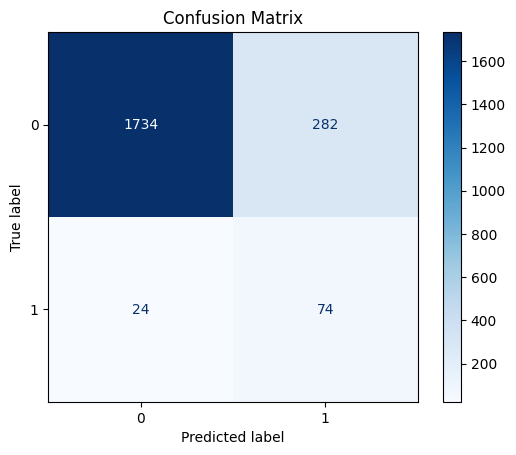

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#using .predict to output individual pred values
y_pred_prob = best_model.predict(X_test_scaled)

y_pred = (y_pred_prob >= 0.5).astype(int).reshape(-1) #use default threshold from keras

cm = confusion_matrix(y_test, y_pred)

#display confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

With reference to the above confusion matrix, the LSTM model is able to accurately classify most of the non-fraud cases and most of the fraudulent cases. This result is much better than the XGBoost and Logistic regression models, making it the ideal model to classify fraud for our dataset.